# GIS Project "ITRF2020"

The International Terrestrial Reference Frame (ITRF) is computed from geodetic data collected at observatories all over the world. The coordinates of the permanent instruments at those sites are quality controlled thanks to the availability of the relative position of these instruments determined with standard surveying techniques. Unfortunately, those observations are expensive and rarely repeated. A working group of the International Association of Geodesy is questioning the use of InSAR technology to monitor the relative displacements of the instruments at those sites.

InSAR analysis is a specific processing that makes use of Synthetic Aperture Radar (SAR) space images of the same area to compute a deformation map with mm/yr accuracy. During the lifetime of a SAR satellite, many SAR images are acquired around the world as a function of the user needs. Thus, we would like to make the inventory of  all SAR images collected from Sentinel 1A and Sentinel 1B satellites that cover each ITRF site in order to investigate if deformation maps could be processed. Indeed, at least 12 images of the same area acquired from the same acquisition geometry (same “relative orbit number”) are required to obtain reliable InSAR results.

We focus on ITRF sites that include at least 2 instruments from 2 different measurement techniques (GNSS, DORIS, SLR or VLBI). Two instruments are located on the same site if their DOMES number (ID number of the instrument) starts with the same 5 numbers.

The objective of this project is to collect and map the footprints all Sentinel 1A and Sentinel 1B satellites that cover ITRF sites that verify the above conditions and integrate them in a GIS project for further analyses.

![Sites, Instruments and Image footprints](img/presentation.png)

## Objectives

The objectif of the projet is to make a Python script to read the position of the ITRF instruments in the given files (see [data](data) directory), calculate the position of the ITRF sites and interrogate an API to list and download the satellite images over theses sites.

We would like as output:
* a SHP with the instrument of the processed sites ;
* a SHP with the extent of the sites ;
* a SHP with the extent of the satellite images to download.

## Data

The [data](data) are 4 textual files with :
* id of the site and id of the instrument in this site (eg: `12345S123` : `12345` + `S123`) ;
* name of the site ;
* type of the instrument ;
* name of the instrument ;
* x position ;
* y position ;
* z position ;
* the x-y-z precision.

Example (`ITRF2020_DORIS_cart.txt`):

```txt
id        name            type  code x             y             z             dx     dy     dz
10002S018 Grasse (OCA)    DORIS GR3B  4581680.3279   556166.4818  4389371.6042 0.0020 0.0025 0.0020
10002S019 Grasse (OCA)    DORIS GR4B  4581681.0445   556166.9141  4389370.9730 0.0019 0.0024 0.0017
10003S001 Toulouse        DORIS TLSA  4628047.2485   119670.6873  4372788.0168 0.0054 0.0062 0.0051
10003S003 Toulouse        DORIS TLHA  4628693.4610   119985.0770  4372104.5078 0.0034 0.0042 0.0032
10003S005 Toulouse        DORIS TLSB  4628693.6567   119985.0787  4372104.7202 0.0026 0.0039 0.0025
10077S002 Ajaccio         DORIS AJAB  4696990.0906   723981.2094  4239679.2709 1.2860 1.2898 1.2857
10202S001 Reykjavik       DORIS REYA  2585527.8355 -1044368.1434  5717159.1052 0.0148 0.0163 0.0090
```

## Project statement

1. Creation of the first SHP (instruments):
   1. Open the 4 files with [pandas](https://pandas.pydata.org/docs/reference/api/pandas.read_fwf.html).
   2. Merge it in a new DataFrame.
   3. Make a GeoDataFrame with all the instruments (convert geometry from `EPSG:4978` to `EPSG:4326`).
   4. Calculate the `site_id` and the `instrument_id` (add new columns).
   5. Remove useless columns.
   6. Save the data!
1. Creation of the second SHP (sites):
   1. Keep only the instruments that belongs to a site (look at the five first numbers of the DOMES (id) number) which hosts at least 3 instruments from 2 different measurement techniques (GNSS, DORIS, SLR or VLBI).
   2. Make a [spatial groupby (dissolve)](https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html) two join all the points from a same site.
   3. Calculate a polygon from the list of points (you will need the shapely [Polygon](https://shapely.readthedocs.io/en/latest/reference/shapely.Polygon.html#shapely.Polygon) function and the shapely [convex_hull](https://shapely.readthedocs.io/en/latest/reference/shapely.MultiPoint.html#shapely.MultiPoint.convex_hull) property).
   4. Save the data!
2. Creation of the last SHP (images):
   1. For each site, list the images (between 2022/01/01 and 2022/09/30) that are covering the extent of the site. This is very long!!! Write the information in a `<site_id>.json` temporary file to be able to restart the script if it fails.
    2. Merge all information in one GeoDataFrame.
    3. Save the data!


## API Access

You do not need to register to use the listing API.

The documentation of the API is here : https://documentation.dataspace.copernicus.eu/APIs/OpenSearch.html

We want to select images according to a **geometry**, a **start date**, an **end data** and a **collection** (`SENTINEL-2`).

Here's an example of a function you can start with:

```py
import requests

def request_images(wkt_geometry):
    items = [] # Empty list to store return elements
    # Request
    r = requests.get(
        "https://catalogue.dataspace.copernicus.eu/resto/api/collections/Sentinel2/search.json",
        params={
            "geometry": wkt_geometry,
            "startDate": "2022-01-01T00:00:00.000Z",
            "completionDate": "2022-09-30T23:59:59.999Z",
            "cloudCover": "[0,10]",
            "maxRecords": 20,
            "page": 1,
        }
    )
    # If status_code is not 200, we have an issue
    if r.status_code == 200:
        data = r.json()
        if 'features' in data:
            items += data['features']
    return items

wkt_geometry = 'POLYGON((2.349250 48.8535,2.348703 48.85293,2.350430 48.8524,2.35091 48.8530,2.349250 48.8535))'
images = request_images(wkt_geometry)
```

Look at the [data/response_example.json](data/response_example.json) file to have a look at the API response.

You may need to do several request if there are more images than the number of rows you ask (while loop). (That is **not** required for the project.)


## Data help

Instrument SHP:
* geometry type: 2d or 3d point (X,Y,Z of the instrument) ;
* `site_id`: id of the site (first 5 chars of the full id) ;
* `name`: name of the site ;
* `id`: full id of the instrument ;
* `code`: code of the instrument ;
* `type`: type of the instrument (DORIS / GNSS / SLR / VLBI) ;

Site SHP:
* geometry type: polygon (extent around the instruments)
* `site_id`: id of the site ;
* `name`: name of the site ;

Images SHP:
* geometry type: polygone (extent of the image)
* `site_id`: id of the site ;
* `id`: id of the image ;
* `title`: title of the image ;
* `thumbnail`: url of the thumbnail image ;
* `url`: url to download the image ;
* `filename`: filename ;
* `orbitNumber`: orbit number ;
* `ron`: relative orbit number ;
* `orbit`: orbit direction (ASCENDING / DESCENDING) ;
* `platform`: platform identifier.


---

## Code

---


### 1. Creation of the first SHP (instruments):

   1. Open the 4 files with [pandas](https://pandas.pydata.org/docs/reference/api/pandas.read_fwf.html).

   2. Merge it in a new DataFrame.
   
   3. Make a GeoDataFrame with all the instruments (convert geometry from `EPSG:4978` to `EPSG:4326`).
   
   4. Calculate the `site_id` and the `instrument_id` (add new columns).
   
   5. Remove useless columns.
   
   6. Save the data!

   Instrument SHP:
* geometry type: 2d or 3d point (X,Y,Z of the instrument) ;
* `site_id`: id of the site (first 5 chars of the full id) ;
* `name`: name of the site ;
* `id`: full id of the instrument ;
* `code`: code of the instrument ;
* `type`: type of the instrument (DORIS / GNSS / SLR / VLBI) ;

In [293]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [294]:
df_doris = pd.read_fwf('data/ITRF2020_DORIS_cart.txt')
df_gnss = pd.read_fwf('data/ITRF2020_GNSS_cart.txt')
df_slr = pd.read_fwf('data/ITRF2020_SLR_cart.txt', na_values='******')
df_vlbi = pd.read_fwf('data/ITRF2020_VLBI_cart.txt')

In [295]:
# df_gnss.head(5)
df_slr.info()
# df_vlbi.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      146 non-null    object 
 1   name    145 non-null    object 
 2   type    146 non-null    object 
 3   code    146 non-null    int64  
 4   x       146 non-null    float64
 5   y       146 non-null    float64
 6   z       146 non-null    float64
 7   dx      144 non-null    float64
 8   dy      144 non-null    float64
 9   dz      144 non-null    float64
dtypes: float64(6), int64(1), object(3)
memory usage: 11.5+ KB


In [296]:
dataframes = [
    df_doris,
    df_gnss,
    df_slr,
    df_vlbi
]
df_itrf = pd.concat(dataframes, ignore_index=True)
df_itrf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1842 entries, 0 to 1841
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      1842 non-null   object 
 1   name    1840 non-null   object 
 2   type    1842 non-null   object 
 3   code    1842 non-null   object 
 4   x       1842 non-null   float64
 5   y       1842 non-null   float64
 6   z       1842 non-null   float64
 7   dx      1840 non-null   float64
 8   dy      1840 non-null   float64
 9   dz      1840 non-null   float64
dtypes: float64(6), object(4)
memory usage: 144.0+ KB


In [297]:
gdf_itrf = gpd.GeoDataFrame(df_itrf, crs='EPSG:4978', geometry=gpd.points_from_xy(df_itrf.x, df_itrf.y, df_itrf.z, crs='EPSG:4978'))

In [298]:
gdf_itrf.head(5)

,id,name,type,code,x,y,z,dx,dy,dz,geometry
0,10002S018,Grasse (OCA),DORIS,GR3B,4.581680e+06,556166.4818,4.389372e+06,0.0020,0.0025,0.0020,POINT Z (4581680.3279 556166.4818 4389371.6042)
1,10002S019,Grasse (OCA),DORIS,GR4B,4.581681e+06,556166.9141,4.389371e+06,0.0019,0.0024,0.0017,POINT Z (4581681.0445 556166.9141 4389370.973)
2,10003S001,Toulouse,DORIS,TLSA,4.628047e+06,119670.6873,4.372788e+06,0.0054,0.0062,0.0051,POINT Z (4628047.2485 119670.6873 4372788.0168)
3,10003S003,Toulouse,DORIS,TLHA,4.628693e+06,119985.0770,4.372105e+06,0.0034,0.0042,0.0032,POINT Z (4628693.461 119985.077 4372104.5078)
4,10003S005,Toulouse,DORIS,TLSB,4.628694e+06,119985.0787,4.372105e+06,0.0026,0.0039,0.0025,POINT Z (4628693.6567 119985.0787 4372104.7202)


In [299]:
gdf_itrf.to_crs('EPSG:4326', inplace=True)
gdf_itrf.head(5)

,id,name,type,code,x,y,z,dx,dy,dz,geometry
0,10002S018,Grasse (OCA),DORIS,GR3B,4.581680e+06,556166.4818,4.389372e+06,0.0020,0.0025,0.0020,POINT Z (6.92123 43.75483 1323.70087)
1,10002S019,Grasse (OCA),DORIS,GR4B,4.581681e+06,556166.9141,4.389371e+06,0.0019,0.0024,0.0017,POINT Z (6.92123 43.75483 1323.8158)
2,10003S001,Toulouse,DORIS,TLSA,4.628047e+06,119670.6873,4.372788e+06,0.0054,0.0062,0.0051,POINT Z (1.48121 43.55814 207.69101)
3,10003S003,Toulouse,DORIS,TLHA,4.628693e+06,119985.0770,4.372105e+06,0.0034,0.0042,0.0032,POINT Z (1.48489 43.54962 210.79597)
4,10003S005,Toulouse,DORIS,TLSB,4.628694e+06,119985.0787,4.372105e+06,0.0026,0.0039,0.0025,POINT Z (1.48489 43.54962 211.08413)


In [300]:
gdf_itrf['site_id'] = gdf_itrf['id'].str.slice(start=0, stop=5)
gdf_itrf['instrument_id'] = gdf_itrf['id'].str.slice(start=5)

In [301]:
gdf_itrf.head(5)

,id,name,type,code,x,y,z,dx,dy,dz,geometry,site_id,instrument_id
0,10002S018,Grasse (OCA),DORIS,GR3B,4.581680e+06,556166.4818,4.389372e+06,0.0020,0.0025,0.0020,POINT Z (6.92123 43.75483 1323.70087),10002,S018
1,10002S019,Grasse (OCA),DORIS,GR4B,4.581681e+06,556166.9141,4.389371e+06,0.0019,0.0024,0.0017,POINT Z (6.92123 43.75483 1323.8158),10002,S019
2,10003S001,Toulouse,DORIS,TLSA,4.628047e+06,119670.6873,4.372788e+06,0.0054,0.0062,0.0051,POINT Z (1.48121 43.55814 207.69101),10003,S001
3,10003S003,Toulouse,DORIS,TLHA,4.628693e+06,119985.0770,4.372105e+06,0.0034,0.0042,0.0032,POINT Z (1.48489 43.54962 210.79597),10003,S003
4,10003S005,Toulouse,DORIS,TLSB,4.628694e+06,119985.0787,4.372105e+06,0.0026,0.0039,0.0025,POINT Z (1.48489 43.54962 211.08413),10003,S005


In [302]:
gdf_itrf[['geometry', 'site_id', 'name', 'id', 'code', 'type']].to_csv('output/instruments.csv')

In [ ]:
gdf_itrf[['geometry', 'site_id', 'name', 'id', 'code', 'type']].to_file('output/shp/instruments.shp')

### 2. Creation of the second SHP (sites):
    
1. Keep only the instruments that belongs to a site (look at the five first numbers of the DOMES (id) number) which hosts at least 3 instruments from 2 different measurement techniques (GNSS, DORIS, SLR or VLBI).
    
2. Make a [spatial groupby (dissolve)](https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html) two join all the points from a same site.
    
3. Calculate a polygon from the list of points (you will need the shapely [Polygon](https://shapely.readthedocs.io/en/latest/reference/shapely.Polygon.html#shapely.Polygon) function and the shapely [convex_hull](https://shapely.readthedocs.io/en/latest/reference/shapely.MultiPoint.html#shapely.MultiPoint.convex_hull) property).
    
4. Save the data!

In [304]:
from shapely import Polygon, MultiPolygon

In [305]:
df_filter = gdf_itrf[['site_id', 'type', 'instrument_id']].groupby('site_id').nunique()
df_filter

,type,instrument_id
site_id,,
10001,1,2
10002,4,7
10003,2,6
10004,2,3
10012,1,2
...,...,...
97309,1,1
97401,2,4
97413,1,1


In [306]:
filter1 = df_filter['type'] >= 2
filter2 = df_filter['instrument_id'] >= 3
valid_site_id = df_filter[filter1*filter2].index
gdf_itrf['site_id'].isin(valid_site_id.to_numpy())

0        True
1        True
2        True
3        True
4        True
        ...  
1837    False
1838    False
1839    False
1840     True
1841     True
Name: site_id, Length: 1842, dtype: bool

In [307]:
valid_site_id.size

105

In [308]:
filter1 = df_filter['type'] >= 2
filter2 = df_filter['instrument_id'] >= 3
valid_site_id = df_filter[filter1*filter2].index.to_numpy()
valid_gdf_itrf = gdf_itrf[gdf_itrf['site_id'].isin(valid_site_id)]
valid_gdf_itrf.head(5)

,id,name,type,code,x,y,z,dx,dy,dz,geometry,site_id,instrument_id
0,10002S018,Grasse (OCA),DORIS,GR3B,4.581680e+06,556166.4818,4.389372e+06,0.0020,0.0025,0.0020,POINT Z (6.92123 43.75483 1323.70087),10002,S018
1,10002S019,Grasse (OCA),DORIS,GR4B,4.581681e+06,556166.9141,4.389371e+06,0.0019,0.0024,0.0017,POINT Z (6.92123 43.75483 1323.8158),10002,S019
2,10003S001,Toulouse,DORIS,TLSA,4.628047e+06,119670.6873,4.372788e+06,0.0054,0.0062,0.0051,POINT Z (1.48121 43.55814 207.69101),10003,S001
3,10003S003,Toulouse,DORIS,TLHA,4.628693e+06,119985.0770,4.372105e+06,0.0034,0.0042,0.0032,POINT Z (1.48489 43.54962 210.79597),10003,S003
4,10003S005,Toulouse,DORIS,TLSB,4.628694e+06,119985.0787,4.372105e+06,0.0026,0.0039,0.0025,POINT Z (1.48489 43.54962 211.08413),10003,S005


In [309]:
# print(valid_gdf_itrf.info())
# print(gdf_itrf.info())
test = valid_gdf_itrf[['site_id', 'geometry']].dissolve(by='site_id')

                                                  geometry
site_id                                                   
10002    MULTIPOINT Z ((6.92058 43.75474 1319.30335), (...
10003    MULTIPOINT Z ((1.48076 43.56077 207.09635), (1...
10004    MULTIPOINT Z ((-4.50383 48.40787 104.42082), (...
10077    MULTIPOINT Z ((8.76246 41.92747 98.24128), (8....
10202    MULTIPOINT Z ((-21.99518 64.15098 95.75501), (...
...                                                    ...
92301    MULTIPOINT Z ((-134.96492 -23.13026 82.2131), ...
92701    MULTIPOINT Z ((166.41006 -22.26983 83.06194), ...
92902    MULTIPOINT Z ((-178.121 -14.30778 85.73272), (...
97301    MULTIPOINT Z ((-52.80597 5.25219 -25.77014), (...
97401    MULTIPOINT Z ((55.57172 -21.20822 1558.37142),...

[105 rows x 1 columns]


<Axes: >

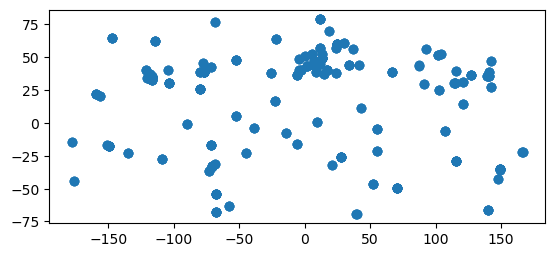

In [310]:
print(test)
test.plot()

In [311]:
sites_polygon = gpd.GeoDataFrame(test['geometry'].apply(lambda x: x.convex_hull))
sites_polygon.reset_index(inplace=True)
sites_polygon = pd.merge(
    left=sites_polygon,
    right=valid_gdf_itrf[['site_id', 'name']].groupby('site_id').first(),
    how='inner',
    left_on='site_id',
    right_on='site_id' 
)
sites_polygon.to_csv('output/sites.csv')

In [312]:
sites_polygon.to_file('output/shp/sites.shp')

In [313]:
sites_polygon.head(5)

,site_id,geometry,name
0,10002,"POLYGON Z ((6.92077 43.75449 1319.85842, 6.920...",Grasse (OCA)
1,10003,"POLYGON Z ((1.48489 43.54962 210.79597, 1.4812...",Toulouse
2,10004,"POLYGON Z ((-4.49659 48.3805 65.82489, -4.5038...",Brest
3,10077,"POLYGON Z ((8.7627 41.92739 96.80211, 8.76246 ...",Ajaccio
4,10202,"POLYGON Z ((-21.95549 64.13879 93.04831, -21.9...",Reykjavik


### 3. Creation of the last SHP (images):

1. For each site, list the images (between 2022/01/01 and 2022/09/30) that are covering the extent of the site. This is very long!!! Write the information in a `<site_id>.json` temporary file to be able to restart the script if it fails.

2. Merge all information in one GeoDataFrame.

3. Save the data!

Images SHP:
* geometry type: polygone (extent of the image)
* `site_id`: id of the site ;
* `id`: id of the image ;
* `title`: title of the image ;
* `thumbnail`: url of the thumbnail image ;
* `url`: url to download the image ;
* `filename`: filename ;
* `orbitNumber`: orbit number ;
* `ron`: relative orbit number ;
* `orbit`: orbit direction (ASCENDING / DESCENDING) ;
* `platform`: platform identifier.

In [205]:
import requests

In [183]:
def request_images(wkt_geometry):
    items = [] # Empty list to store return elements
    # Request
    r = requests.get(
        "https://catalogue.dataspace.copernicus.eu/resto/api/collections/Sentinel2/search.json",
        params={
            "geometry": wkt_geometry,
            "startDate": "2022-01-01T00:00:00.000Z",
            "completionDate": "2022-09-30T23:59:59.999Z",
            "cloudCover": "[0,10]",
            "maxRecords": 20,
            "page": 1,
        }
    )
    # If status_code is not 200, we have an issue
    if r.status_code == 200:
        data = r.json()
        if 'features' in data:
            items += data['features']
    return items

In [351]:
# df_images = pd.DataFrame(None, columns=['geometry_type', 'site_id', 'id', 'title', 'thumbnail', 'url', 'filename', 'orbitNumber', 'ron', 'orbit', 'platform', 'geometry'])
for i in range(84, sites_polygon.shape[0]):
# for i in range(2):
    print(i / range(sites_polygon.shape[0]).stop * 100 // 1)
    site_id = sites_polygon['site_id'].iloc[i]
    wkt_geometry = sites_polygon['geometry'].iloc[i].wkt
    images = request_images(wkt_geometry)
    for image in images:
        try:
            poly = Polygon(image['geometry']['coordinates'][0])
        except:
            poly = Polygon(image['geometry']['coordinates'][0][0])
        df_aux = pd.DataFrame({
            'geometry_type': image['geometry']['type'],
            'site_id': site_id,
            'id': image['id'],
            'title': image['properties']['title'],
            'thumbnail': image['properties']['thumbnail'],
            'url': image['properties']['services']['download']['url'],
            'filename': image['properties']['productIdentifier'],
            'orbitNumber': image['properties']['orbitNumber'],
            'ron': image['properties']['relativeOrbitNumber'],
            'orbit': image['properties']['orbitDirection'],
            'platform': image['properties']['platform'],
            'geometry': poly
        }, index=[0])
        df_images = pd.concat([df_images, df_aux], axis=0, ignore_index=True)
        df_images.to_csv('output/images.csv')

80.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0


In [349]:
sites_polygon['site_id'].iloc[i]

'42202'

In [350]:
image

{'type': 'Feature',
 'id': '7fcfd073-3628-521b-abb7-e104447794a0',
 'geometry': {'type': 'MultiPolygon',
  'coordinates': [[[[-70.78879, -17.205991735425],
     [-70.78009, -16.273346049311],
     [-71.806885, -16.26221844787],
     [-71.81714, -16.958730194705],
     [-71.793304, -16.963957159226],
     [-71.793396, -16.964328533919],
     [-71.78128, -16.967102490297],
     [-71.78116, -16.966520809858],
     [-71.78113, -16.966521827356],
     [-71.78113, -16.966439245468],
     [-71.78049, -16.966588510203],
     [-71.78046, -16.966537965998],
     [-71.57498, -17.013796087883],
     [-71.57504, -17.014158138018],
     [-71.57495, -17.014182919967],
     [-71.57498, -17.014319941301],
     [-71.57492, -17.014331144551],
     [-71.57495, -17.014375337967],
     [-71.34842, -17.067198826027],
     [-71.34265, -17.068604520474],
     [-71.3425, -17.067967968995],
     [-71.3425, -17.067967733963],
     [-71.341736, -17.068151225004],
     [-71.341736, -17.068049434781],
     [-71.1336

In [332]:
gpd.GeoDataFrame(df_images).head(5)

,geometry_type,site_id,id,title,thumbnail,url,filename,orbitNumber,ron,orbit,platform,geometry
0,Polygon,10002,3af0b46f-b626-5ad2-af5a-9b75beae12df,S2B_MSIL1C_20220129T103159_N0400_R108_T32TLP_2...,https://catalogue.dataspace.copernicus.eu/get-...,https://catalogue.dataspace.copernicus.eu/down...,/eodata/Sentinel-2/MSI/L1C/2022/01/29/S2B_MSIL...,25588,108,DESCENDING,S2B,"POLYGON ((7.88335 43.54534, 7.87024 44.24783, ..."
1,Polygon,10002,3fb65452-79f3-59eb-b944-85f664ab1cc1,S2A_MSIL2A_20220121T102331_N9999_R065_T32TLP_2...,https://catalogue.dataspace.copernicus.eu/get-...,https://catalogue.dataspace.copernicus.eu/down...,/eodata/Sentinel-2/MSI/L2A/2022/01/21/S2A_MSIL...,34382,65,DESCENDING,S2A,"POLYGON ((6.53538 43.27203, 6.53677 43.23826, ..."
2,Polygon,10002,d5962479-5473-52c2-93b7-ad0b3823a658,S2A_MSIL1C_20220124T103331_N0301_R108_T32TLP_2...,https://catalogue.dataspace.copernicus.eu/get-...,https://catalogue.dataspace.copernicus.eu/down...,/eodata/Sentinel-2/MSI/L1C/2022/01/24/S2A_MSIL...,34425,108,DESCENDING,S2A,"POLYGON ((7.883 43.56409, 7.87024 44.24783, 6...."
3,Polygon,10002,63d2aee3-51bf-54c1-b37c-21a6da00f0ee,S2A_MSIL2A_20220124T103331_N0301_R108_T32TLP_2...,https://catalogue.dataspace.copernicus.eu/get-...,https://catalogue.dataspace.copernicus.eu/down...,/eodata/Sentinel-2/MSI/L2A/2022/01/24/S2A_MSIL...,34425,108,DESCENDING,S2A,"POLYGON ((7.883 43.56409, 7.87024 44.24783, 6...."
4,Polygon,10002,7b242d90-95f1-545c-86c0-75d3913239cc,S2B_MSIL2A_20220109T103319_N0301_R108_T32TLP_2...,https://catalogue.dataspace.copernicus.eu/get-...,https://catalogue.dataspace.copernicus.eu/down...,/eodata/Sentinel-2/MSI/L2A/2022/01/09/S2B_MSIL...,25302,108,DESCENDING,S2B,"POLYGON ((7.88293 43.56756, 7.83512 43.44629, ..."


In [353]:
merge = pd.merge(
    left=df_images,
    right=sites_polygon[['site_id', 'name']],
    how='left',
    left_on='site_id',
    right_on='site_id'
)
merge
gpd.GeoDataFrame(merge, geometry=merge['geometry'], crs='EPSG:4326').to_file('output/shp/images.shp')

/var/folders/ft/5nh2n43n2fn1l2c_tskjdhjm0000gn/T/ipykernel_25185/3938715723.py:9: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gpd.GeoDataFrame(merge, geometry=merge['geometry'], crs='EPSG:4326').to_file('output/shp/images.shp')
/Users/juani/opt/miniconda3/envs/gdm4_gitlab/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'geometry_type' to 'geometry_t'
  ogr_write(
/Users/juani/opt/miniconda3/envs/gdm4_gitlab/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'orbitNumber' to 'orbitNumbe'
  ogr_write(
